In [65]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split

# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE

# Note: Some metrics need to be defined manually

In [66]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE
    
# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator
    
    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [67]:
#load data(sometimes need to use "/")
#df = pd.read_csv('D:/pythonData/python_demo_data/Rainfall_Forecast.csv')
# Colab
df = pd.read_csv('/content/5269done.csv')
df

,Year,Month,Day,Y
0,2012,10,3,83.174904
1,2012,10,4,83.174904
2,2012,10,5,85.551331
3,2012,10,8,83.174904
4,2012,10,9,83.174904
...,...,...,...,...
2595,2023,5,18,1180.000000
2596,2023,5,19,1230.000000
2597,2023,5,22,1250.000000
2598,2023,5,23,1280.000000


# 1. Preparations for time-series data

Note: Pandas has a specific data type for time-series data

In [68]:
# 1.1 Convert date
df['Date']=pd.to_datetime(df.iloc[:,[0,1,2]])
df

,Year,Month,Day,Y,Date
0,2012,10,3,83.174904,2012-10-03
1,2012,10,4,83.174904,2012-10-04
2,2012,10,5,85.551331,2012-10-05
3,2012,10,8,83.174904,2012-10-08
4,2012,10,9,83.174904,2012-10-09
...,...,...,...,...,...
2595,2023,5,18,1180.000000,2023-05-18
2596,2023,5,19,1230.000000,2023-05-19
2597,2023,5,22,1250.000000,2023-05-22
2598,2023,5,23,1280.000000,2023-05-23


In [69]:
# Date is converted into special data type of pandas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Year    2600 non-null   int64         
 1   Month   2600 non-null   int64         
 2   Day     2600 non-null   int64         
 3   Y       2595 non-null   float64       
 4   Date    2600 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 101.7 KB


In [70]:
new_df=df.iloc[:,[4,3]].copy()
new_df.head()

,Date,Y
0,2012-10-03,83.174904
1,2012-10-04,83.174904
2,2012-10-05,85.551331
3,2012-10-08,83.174904
4,2012-10-09,83.174904


In [71]:
# View descriptive statistics of target variable
# Pandas will automatically ignore date if the correct data type has been converted
new_df.describe()

,Y
count,2595.000000
mean,595.128215
std,575.562470
min,28.754751
25%,157.794678
50%,356.500000
75%,902.500000
max,2365.000000


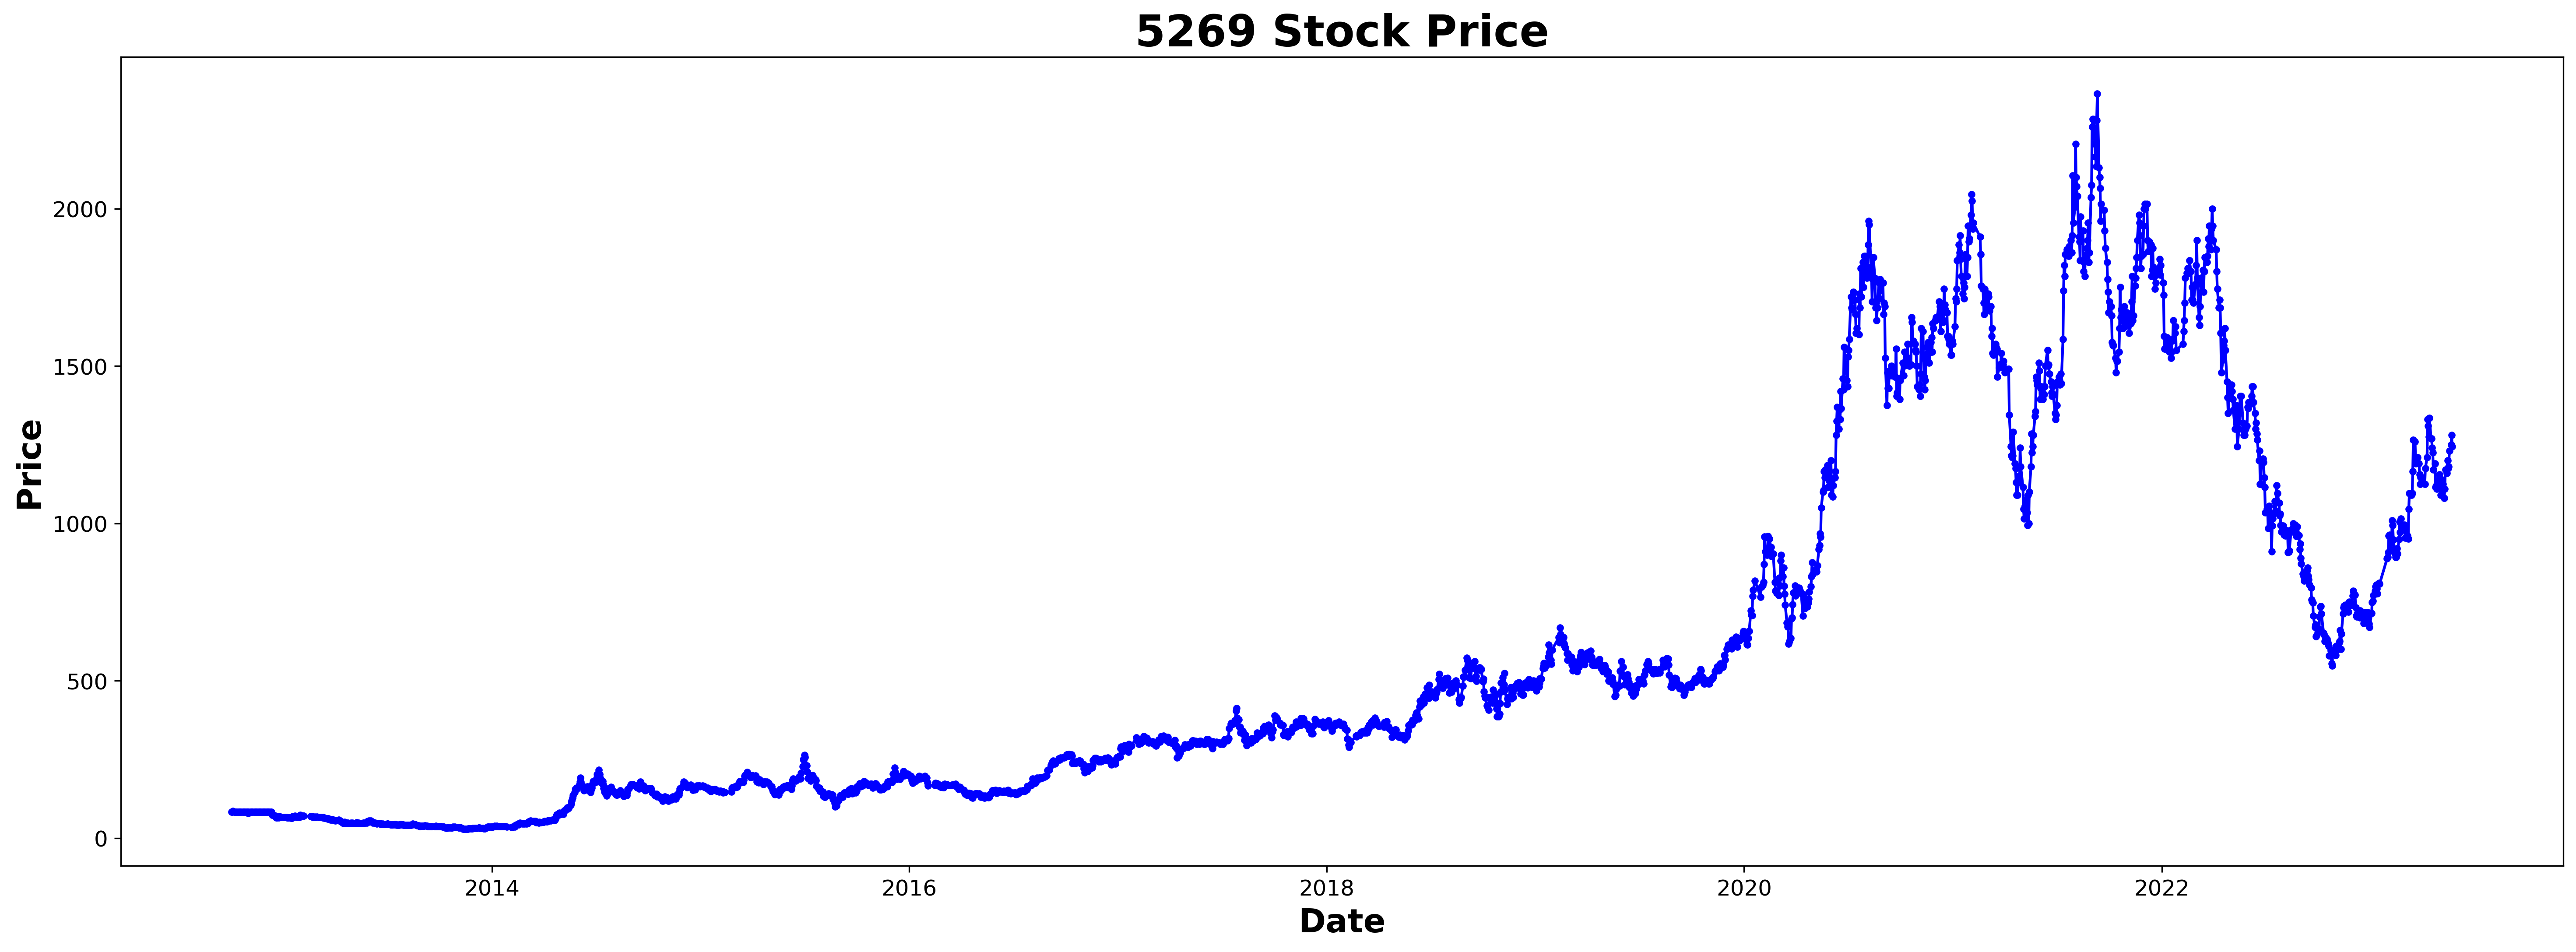

In [72]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('5269 Stock Price',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Price',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(new_df['Date'],new_df['Y'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# 2. Creating time lags as predictor variables

# Important!: Be caution when dealing with time-series data

python do have various packages and function that can deal with time-series data with ease, however, make sure that you understand the fundamental first!

In [73]:
# Create 3 lags
new_df['Lag_1']=new_df['Y'].shift(1).copy()
new_df['Lag_2']=new_df['Y'].shift(2).copy()
new_df['Lag_3']=new_df['Y'].shift(3).copy()
new_df.head()

,Date,Y,Lag_1,Lag_2,Lag_3
0,2012-10-03,83.174904,NaN,NaN,NaN
1,2012-10-04,83.174904,83.174904,NaN,NaN
2,2012-10-05,85.551331,83.174904,83.174904,NaN
3,2012-10-08,83.174904,85.551331,83.174904,83.174904
4,2012-10-09,83.174904,83.174904,85.551331,83.174904


In [74]:
# Drop out missing values and rest index
clean_df=new_df.dropna(axis=0, how='any').copy()
clean_df=clean_df.reset_index(drop=True)
clean_df

,Date,Y,Lag_1,Lag_2,Lag_3
0,2012-10-08,83.174904,85.551331,83.174904,83.174904
1,2012-10-09,83.174904,83.174904,85.551331,83.174904
2,2012-10-11,83.174904,83.174904,83.174904,85.551331
3,2012-10-12,83.174904,83.174904,83.174904,83.174904
4,2012-10-15,83.174904,83.174904,83.174904,83.174904
...,...,...,...,...,...
2572,2023-05-18,1180.000000,1175.000000,1200.000000,1160.000000
2573,2023-05-19,1230.000000,1180.000000,1175.000000,1200.000000
2574,2023-05-22,1250.000000,1230.000000,1180.000000,1175.000000
2575,2023-05-23,1280.000000,1250.000000,1230.000000,1180.000000


In [75]:
# Export the data
#clean_df.to_csv('/content/5269processed.csv',index=False, header=True)
# Colab
#clean_df.to_csv('Rainfall_Lags.csv',index=False, header=True)

# 3. Data preprocessing under time-series structure

A total of 21 years are in the data set. In this practice, we will use the last three years of data as the testing set

In [76]:
# Train data
Forecast_train_data=clean_df.iloc[0:1998,:].copy()
Forecast_train_data

,Date,Y,Lag_1,Lag_2,Lag_3
0,2012-10-08,83.174904,85.551331,83.174904,83.174904
1,2012-10-09,83.174904,83.174904,85.551331,83.174904
2,2012-10-11,83.174904,83.174904,83.174904,85.551331
3,2012-10-12,83.174904,83.174904,83.174904,83.174904
4,2012-10-15,83.174904,83.174904,83.174904,83.174904
...,...,...,...,...,...
1993,2020-12-23,1595.000000,1595.000000,1670.000000,1680.000000
1994,2020-12-24,1585.000000,1595.000000,1595.000000,1670.000000
1995,2020-12-25,1570.000000,1585.000000,1595.000000,1595.000000
1996,2020-12-28,1535.000000,1570.000000,1585.000000,1595.000000


In [77]:
# Test data
Forecast_test_data=clean_df.iloc[1998:1998+579,:].copy()
Forecast_test_data

,Date,Y,Lag_1,Lag_2,Lag_3
1998,2020-12-30,1580.0,1535.0,1535.0,1570.0
1999,2020-12-31,1570.0,1580.0,1535.0,1535.0
2000,2021-01-04,1625.0,1570.0,1580.0,1535.0
2001,2021-01-05,1715.0,1625.0,1570.0,1580.0
2002,2021-01-06,1705.0,1715.0,1625.0,1570.0
...,...,...,...,...,...
2572,2023-05-18,1180.0,1175.0,1200.0,1160.0
2573,2023-05-19,1230.0,1180.0,1175.0,1200.0
2574,2023-05-22,1250.0,1230.0,1180.0,1175.0
2575,2023-05-23,1280.0,1250.0,1230.0,1180.0


# 4. Prepare time-series data for train/validation structure manually

Here we have a total of 18 years of data in training data set that are ready to be further splitted into training and validation data set

18 years of data can be evenlly divided into 6 portions (3 years in each portion)

# Expanding window

# Rolling window

In [78]:
# Rolling 1
Rol_training_1=Forecast_train_data.iloc[0:666,:].copy()
Rol_val_1=Forecast_train_data.iloc[666:666+666,:].copy()

# Rolling 2
Rol_training_2=Forecast_train_data.iloc[666:1332,:].copy()
Rol_val_2=Forecast_train_data.iloc[1332:1332+666,:].copy()

# Rolling 3
Rol_training_3=Forecast_train_data.iloc[1332:1998,:].copy()
Rol_val_3=Forecast_train_data.iloc[1998:1998+579,:].copy()

# 5. Set dependent variable(Y or target) & independent variable(X) 

In [79]:
#set x (make prediction)
# Train
x_train=Rol_training_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingT=MMscaler.fit_transform(x_train)
scaled_x_train=pd.DataFrame(data=scalingT)
scaled_x_train.columns=['Lag_1','Lag_2','Lag_3']

# Validation
x_val=Rol_val_1.drop(['Date','Y'],axis=1).copy()
#minimax scaling
MMscaler=MinMaxScaler(feature_range=(0, 1))
scalingV=MMscaler.fit_transform(x_val)
scaled_x_val=pd.DataFrame(data=scalingV)
scaled_x_val.columns=['Lag_1','Lag_2','Lag_3']

#set y (want to predict)
y_train=Rol_training_1['Y'].copy()
y_val=Rol_val_1['Y'].copy()

# 6. Creating Net 

In [80]:
# Quick recap: Total of 12 features in the data set
scaled_x_train.head()

,Lag_1,Lag_2,Lag_3
0,0.301387,0.288777,0.288777
1,0.288777,0.301387,0.288777
2,0.288777,0.288777,0.301387
3,0.288777,0.288777,0.288777
4,0.288777,0.288777,0.288777


In [81]:
# Tips: Using shape to call the amount of features in the data set 
input_features=scaled_x_train.shape[1]
print('Amount of features:',input_features)

Amount of features: 3


# Important: Define customized loss function (RMSE)

In [82]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

Note: As far as I know when I'm preparing this in-class material, keras does not have a built-in RMSE function. Rumor has it that a RMSE function is hidden in the latest version, however it needs to be confirmed. For instance, defining RMSE ourself is not difficult, just don't forget to register our custom functions.   

# Sequential style coding for creating net

In [83]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(Dense(units=6, input_dim=3, activation='relu'))

# 6.3 Add second hidden layer
model.add(Dense(units=12, activation='linear'))

# 6.4 Add third hidden layer
model.add(Dense(units=24, activation='relu'))

# 6.5 Add second hidden layer
model.add(Dense(units=48, activation='linear'))

# 6.6 Add output layer
model.add(Dense(units=1, activation='relu'))

# 6.7 Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
#opt=Adam(learning_rate=0.002,beta_1=0.95)
opt=Adam(learning_rate=0.001,beta_1=0.70)
model.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 48)                1200      
                                                                 
 dense_4 (Dense)             (None, 1)                 49        
                                                                 
Total params: 1,669
Trainable params: 1,669
Non-trainable params: 0
_________________________________________________________________


Note: Remember to clear the session or else some of the left neurans may cause trouble while fitting

# 7. Fit the model (train/validation)

In [84]:
# 7.1 Store in the history for more useful information
history=model.fit(scaled_x_train, y_train, epochs=300, batch_size=64,verbose=1,validation_data=(scaled_x_val, y_val))

Epoch 1/300
11/11 [==============================] - 1s 21ms/step - loss: 97.2860 - mean_absolute_percentage_error: 100.0000 - val_loss: 248.2988 - val_mean_absolute_percentage_error: 100.0000
Epoch 2/300
11/11 [==============================] - 0s 14ms/step - loss: 97.2860 - mean_absolute_percentage_error: 100.0000 - val_loss: 248.2988 - val_mean_absolute_percentage_error: 100.0000
Epoch 3/300
11/11 [==============================] - 0s 8ms/step - loss: 97.2860 - mean_absolute_percentage_error: 100.0000 - val_loss: 248.2988 - val_mean_absolute_percentage_error: 100.0000
Epoch 4/300
11/11 [==============================] - 0s 9ms/step - loss: 97.2860 - mean_absolute_percentage_error: 100.0000 - val_loss: 248.2988 - val_mean_absolute_percentage_error: 100.0000
Epoch 5/300
11/11 [==============================] - 0s 8ms/step - loss: 97.2860 - mean_absolute_percentage_error: 100.0000 - val_loss: 248.2988 - val_mean_absolute_percentage_error: 100.0000
Epoch 6/300
11/11 [===================

In [85]:
# Check the dictionary keys
modeling_result=history.history
modeling_result.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])

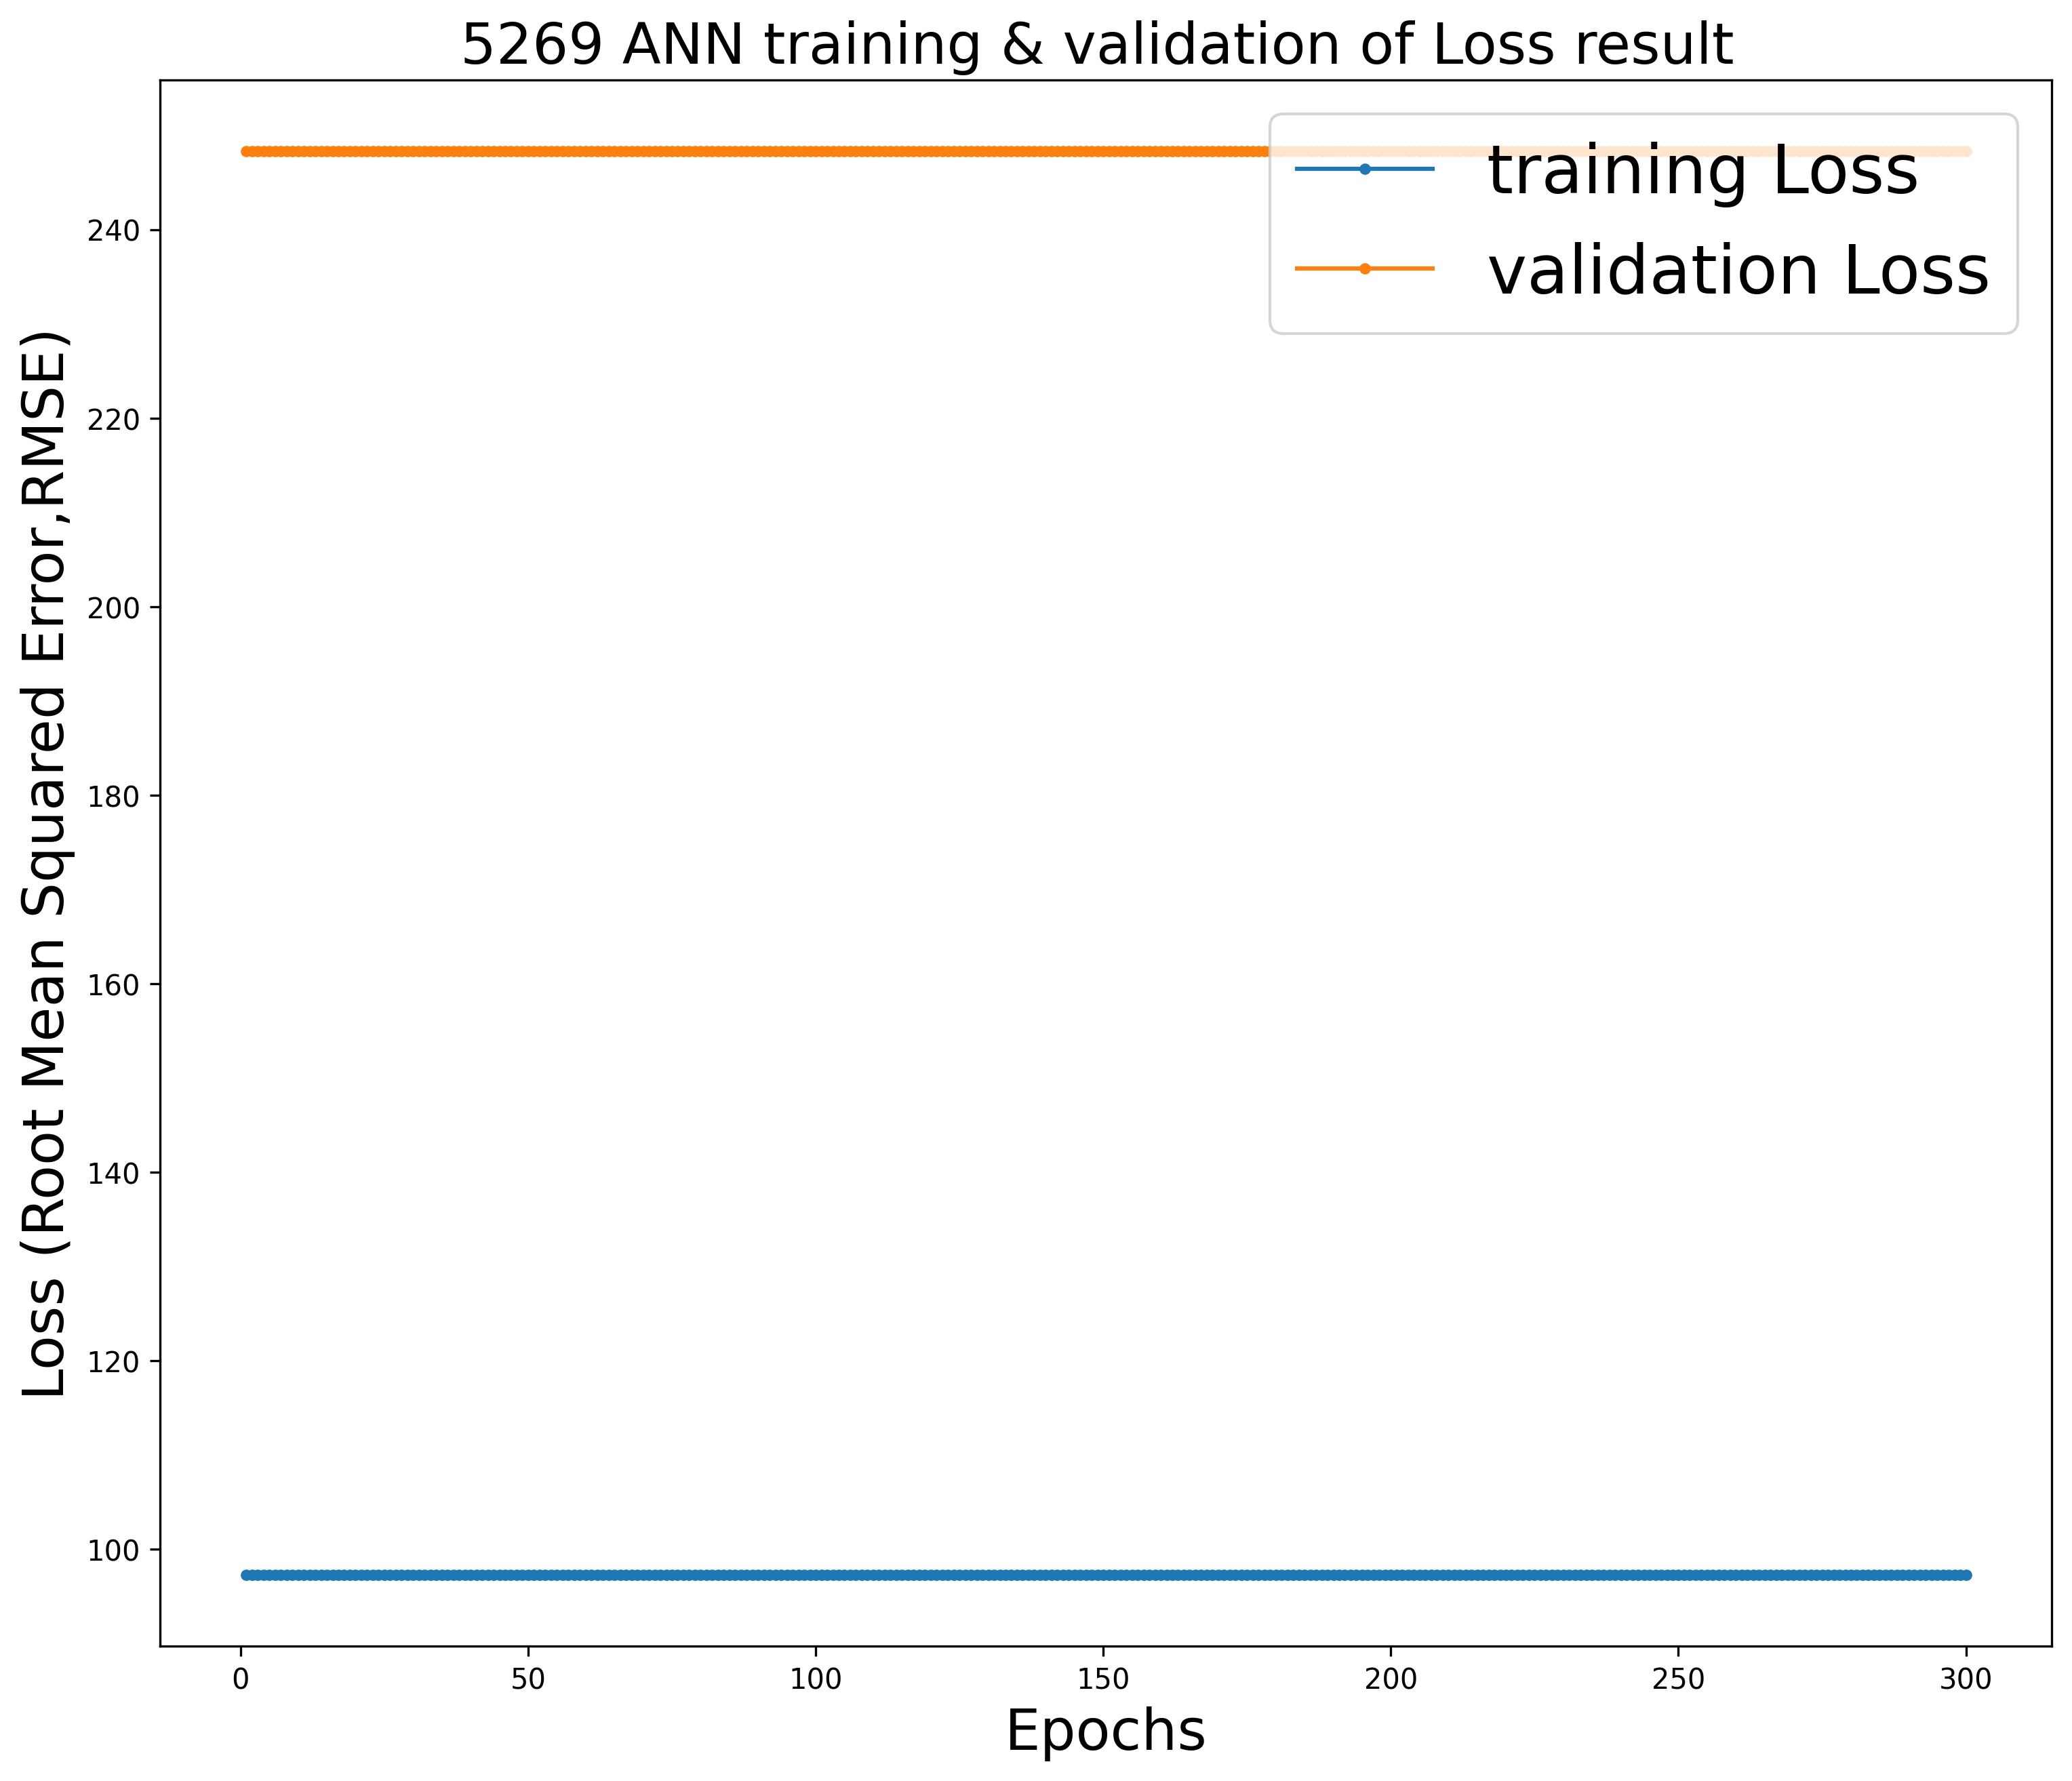

In [86]:
# 7.2 Plot the history of training and validation
training_loss_values=modeling_result['loss']
val_loss_values=modeling_result['val_loss']
epochs=range(1,len(training_loss_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Loss (Root Mean Squared Error,RMSE)',fontsize=20)
plt.title('5269 ANN training & validation of Loss result ',fontsize=20)

plt.plot(epochs, training_loss_values,marker='.',label='training Loss')
plt.plot(epochs, val_loss_values,marker='.',label='validation Loss')
plt.legend(loc=1,fontsize=24)
plt.show()

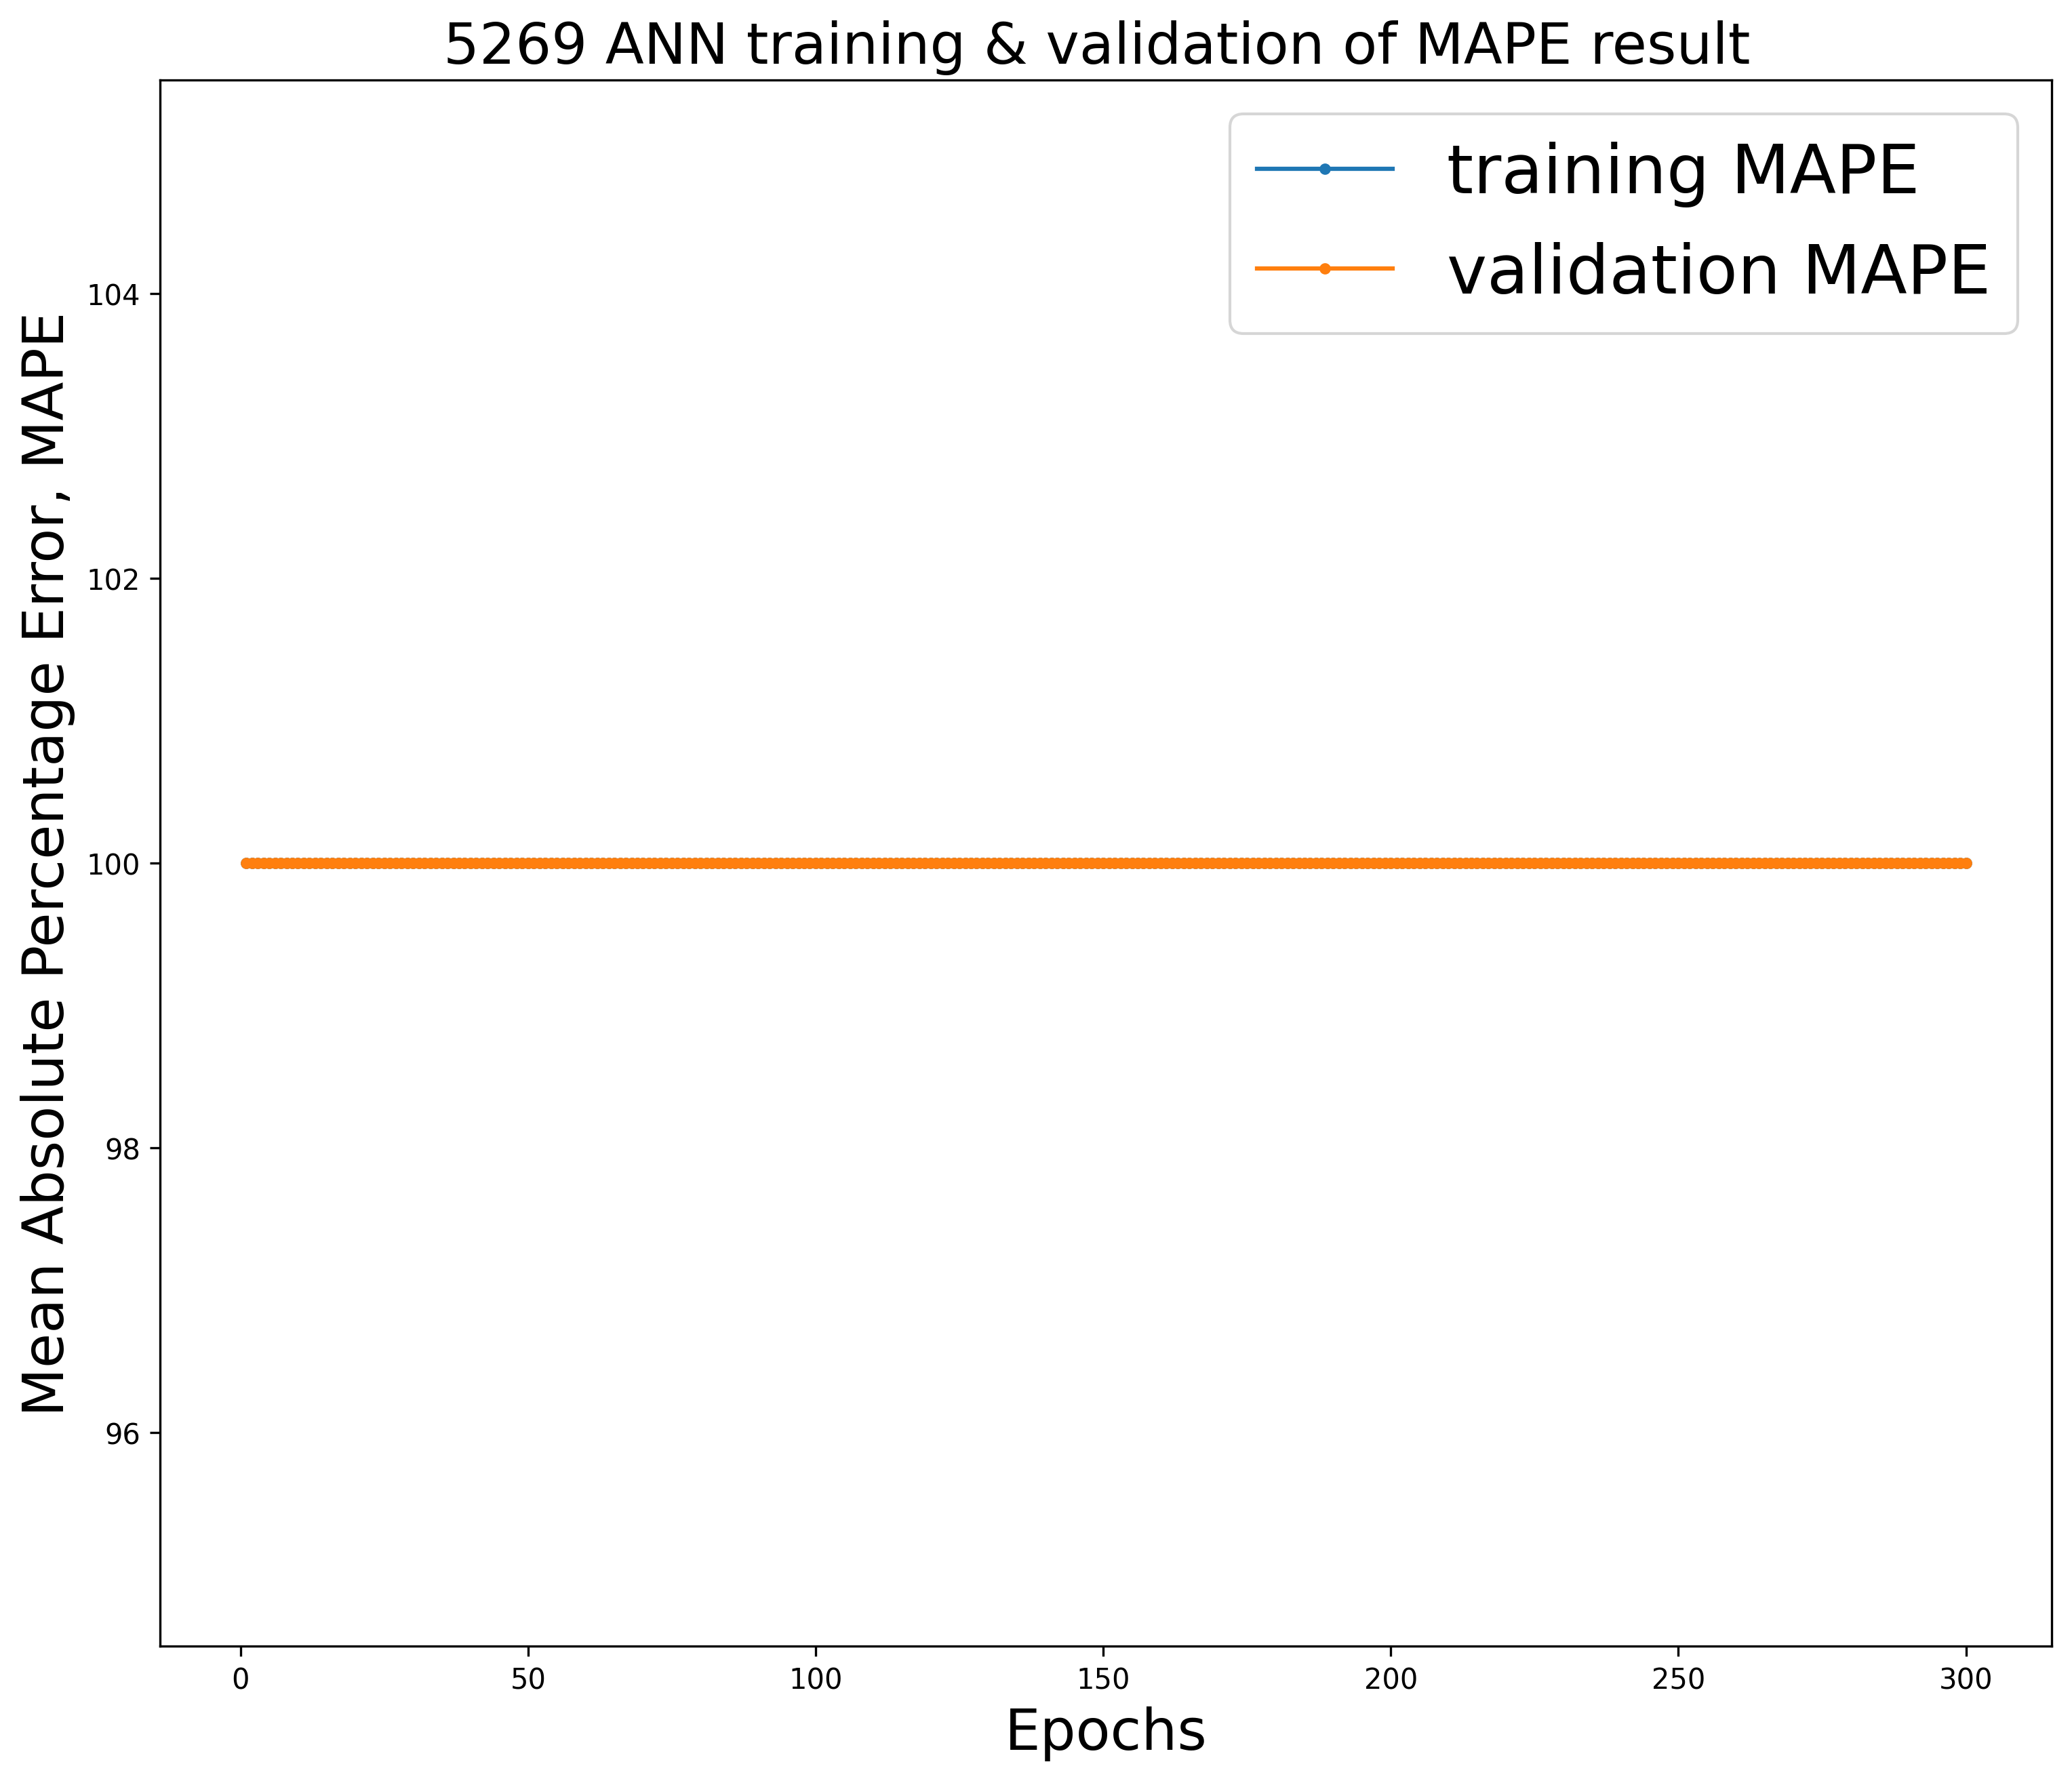

In [87]:
# 7.2 Plot the history of training and validation
training_acc_values=modeling_result['mean_absolute_percentage_error']
val_acc_values=modeling_result['val_mean_absolute_percentage_error']
epochs=range(1,len(training_acc_values)+1)

plt.figure(figsize=(12,10),dpi=300)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('Mean Absolute Percentage Error, MAPE',fontsize=20)
plt.title('5269 ANN training & validation of MAPE result ',fontsize=20)

plt.plot(epochs, training_acc_values,marker='.',label='training MAPE')
plt.plot(epochs, val_acc_values,marker='.',label='validation MAPE')
plt.legend(loc=1,fontsize=24)
plt.show()

# Fit the final model with all of the training data

In [88]:
# X all train data
x_forecast_train=Forecast_train_data.drop(['Date','Y'],axis=1).copy()
# Y all train data
y_forecast_train=Forecast_train_data['Y'].copy()

In [89]:
# Create the model
clear.clear_session()
Fmodel=Sequential()

# Add input layer & first hidden layer
Fmodel.add(Dense(units=6, input_dim=3, activation='relu'))

# Add second hidden layer
Fmodel.add(Dense(units=12, activation='linear'))

# Add third hidden layer
Fmodel.add(Dense(units=24, activation='relu'))

# Add output layer
Fmodel.add(Dense(units=1, activation='linear'))

# Compile the defined Net
#opt=SGD(learning_rate=0.001,momentum=0.5)
#opt=Adam(learning_rate=0.002,beta_1=0.95)
opt=Adam(learning_rate=0.001,beta_1=0.70)
Fmodel.compile(loss='my_RMSE', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model 
Fmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 24        
                                                                 
 dense_1 (Dense)             (None, 12)                84        
                                                                 
 dense_2 (Dense)             (None, 24)                312       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 445
Trainable params: 445
Non-trainable params: 0
_________________________________________________________________


In [90]:
# Store in the history for more useful information
history=Fmodel.fit(x_forecast_train, y_forecast_train, epochs=300, batch_size=32,verbose=1)

Epoch 1/300
63/63 [==============================] - 1s 2ms/step - loss: 312.8357 - mean_absolute_percentage_error: 83.1472
Epoch 2/300
63/63 [==============================] - 0s 2ms/step - loss: 28.4980 - mean_absolute_percentage_error: 7.4115
Epoch 3/300
63/63 [==============================] - 0s 2ms/step - loss: 15.4009 - mean_absolute_percentage_error: 4.0270
Epoch 4/300
63/63 [==============================] - 0s 2ms/step - loss: 15.6389 - mean_absolute_percentage_error: 4.0035
Epoch 5/300
63/63 [==============================] - 0s 2ms/step - loss: 15.6522 - mean_absolute_percentage_error: 4.0371
Epoch 6/300
63/63 [==============================] - 0s 2ms/step - loss: 15.5278 - mean_absolute_percentage_error: 4.0571
Epoch 7/300
63/63 [==============================] - 0s 1ms/step - loss: 15.1304 - mean_absolute_percentage_error: 3.9055
Epoch 8/300
63/63 [==============================] - 0s 2ms/step - loss: 15.3402 - mean_absolute_percentage_error: 3.9835
Epoch 9/300
63/63 [===

In [91]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
Fmodel.save('House_Rent_ANN_trained_model.h5')
print('Model has been saved...')

Model has been saved...


In [92]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('/content/House_Rent_ANN_trained_model.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [93]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Y'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Y'].copy()

In [94]:
# 8.1 Make prediction 
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [95]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Y'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
1998,2020-12-30,1580.0,1524.689941,55.310059
1999,2020-12-31,1570.0,1560.520020,9.479980
2000,2021-01-04,1625.0,1557.520020,67.479980
2001,2021-01-05,1715.0,1603.989990,111.010010
2002,2021-01-06,1705.0,1684.780029,20.219971
...,...,...,...,...
2572,2023-05-18,1180.0,1168.209961,11.790039
2573,2023-05-19,1230.0,1171.180054,58.819946
2574,2023-05-22,1250.0,1212.189941,37.810059
2575,2023-05-23,1280.0,1234.910034,45.089966


In [96]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 39.916
MSE: 2863.511
RMSE: 53.512
MAPE: 2.907 %
SMAPE: 2.928 %
RAE: 0.107
MRAE: 0.00018556753090801813
MdRAE: 0.099 bench: 1361.651
RSE: 0.015
RRSE: 0.124


#  Plot for comparing true value & predicted value 

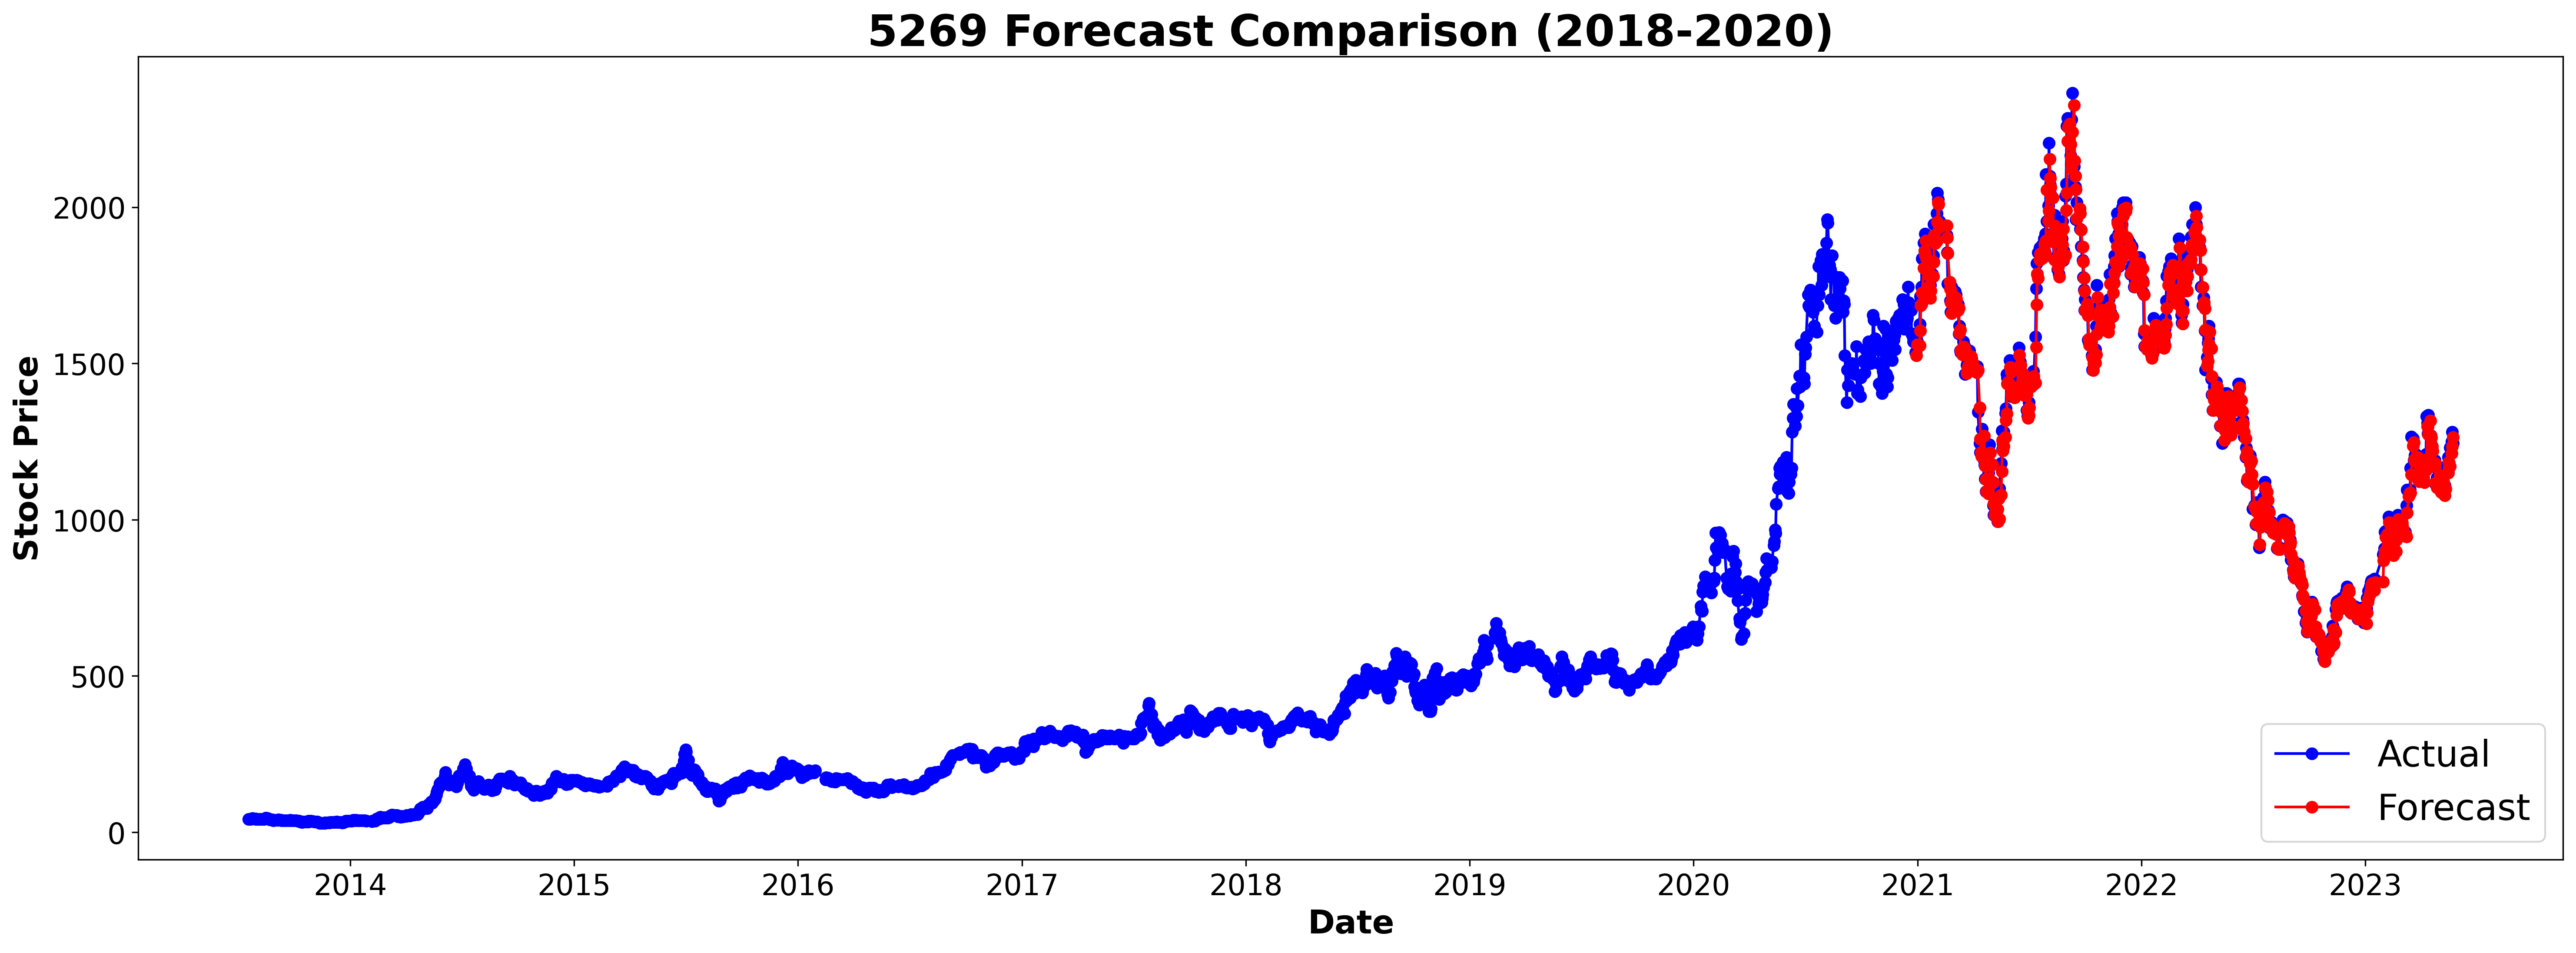

In [97]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('5269 Forecast Comparison (2018-2020)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Stock Price',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(clean_df.iloc[189:,0],clean_df.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')

# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

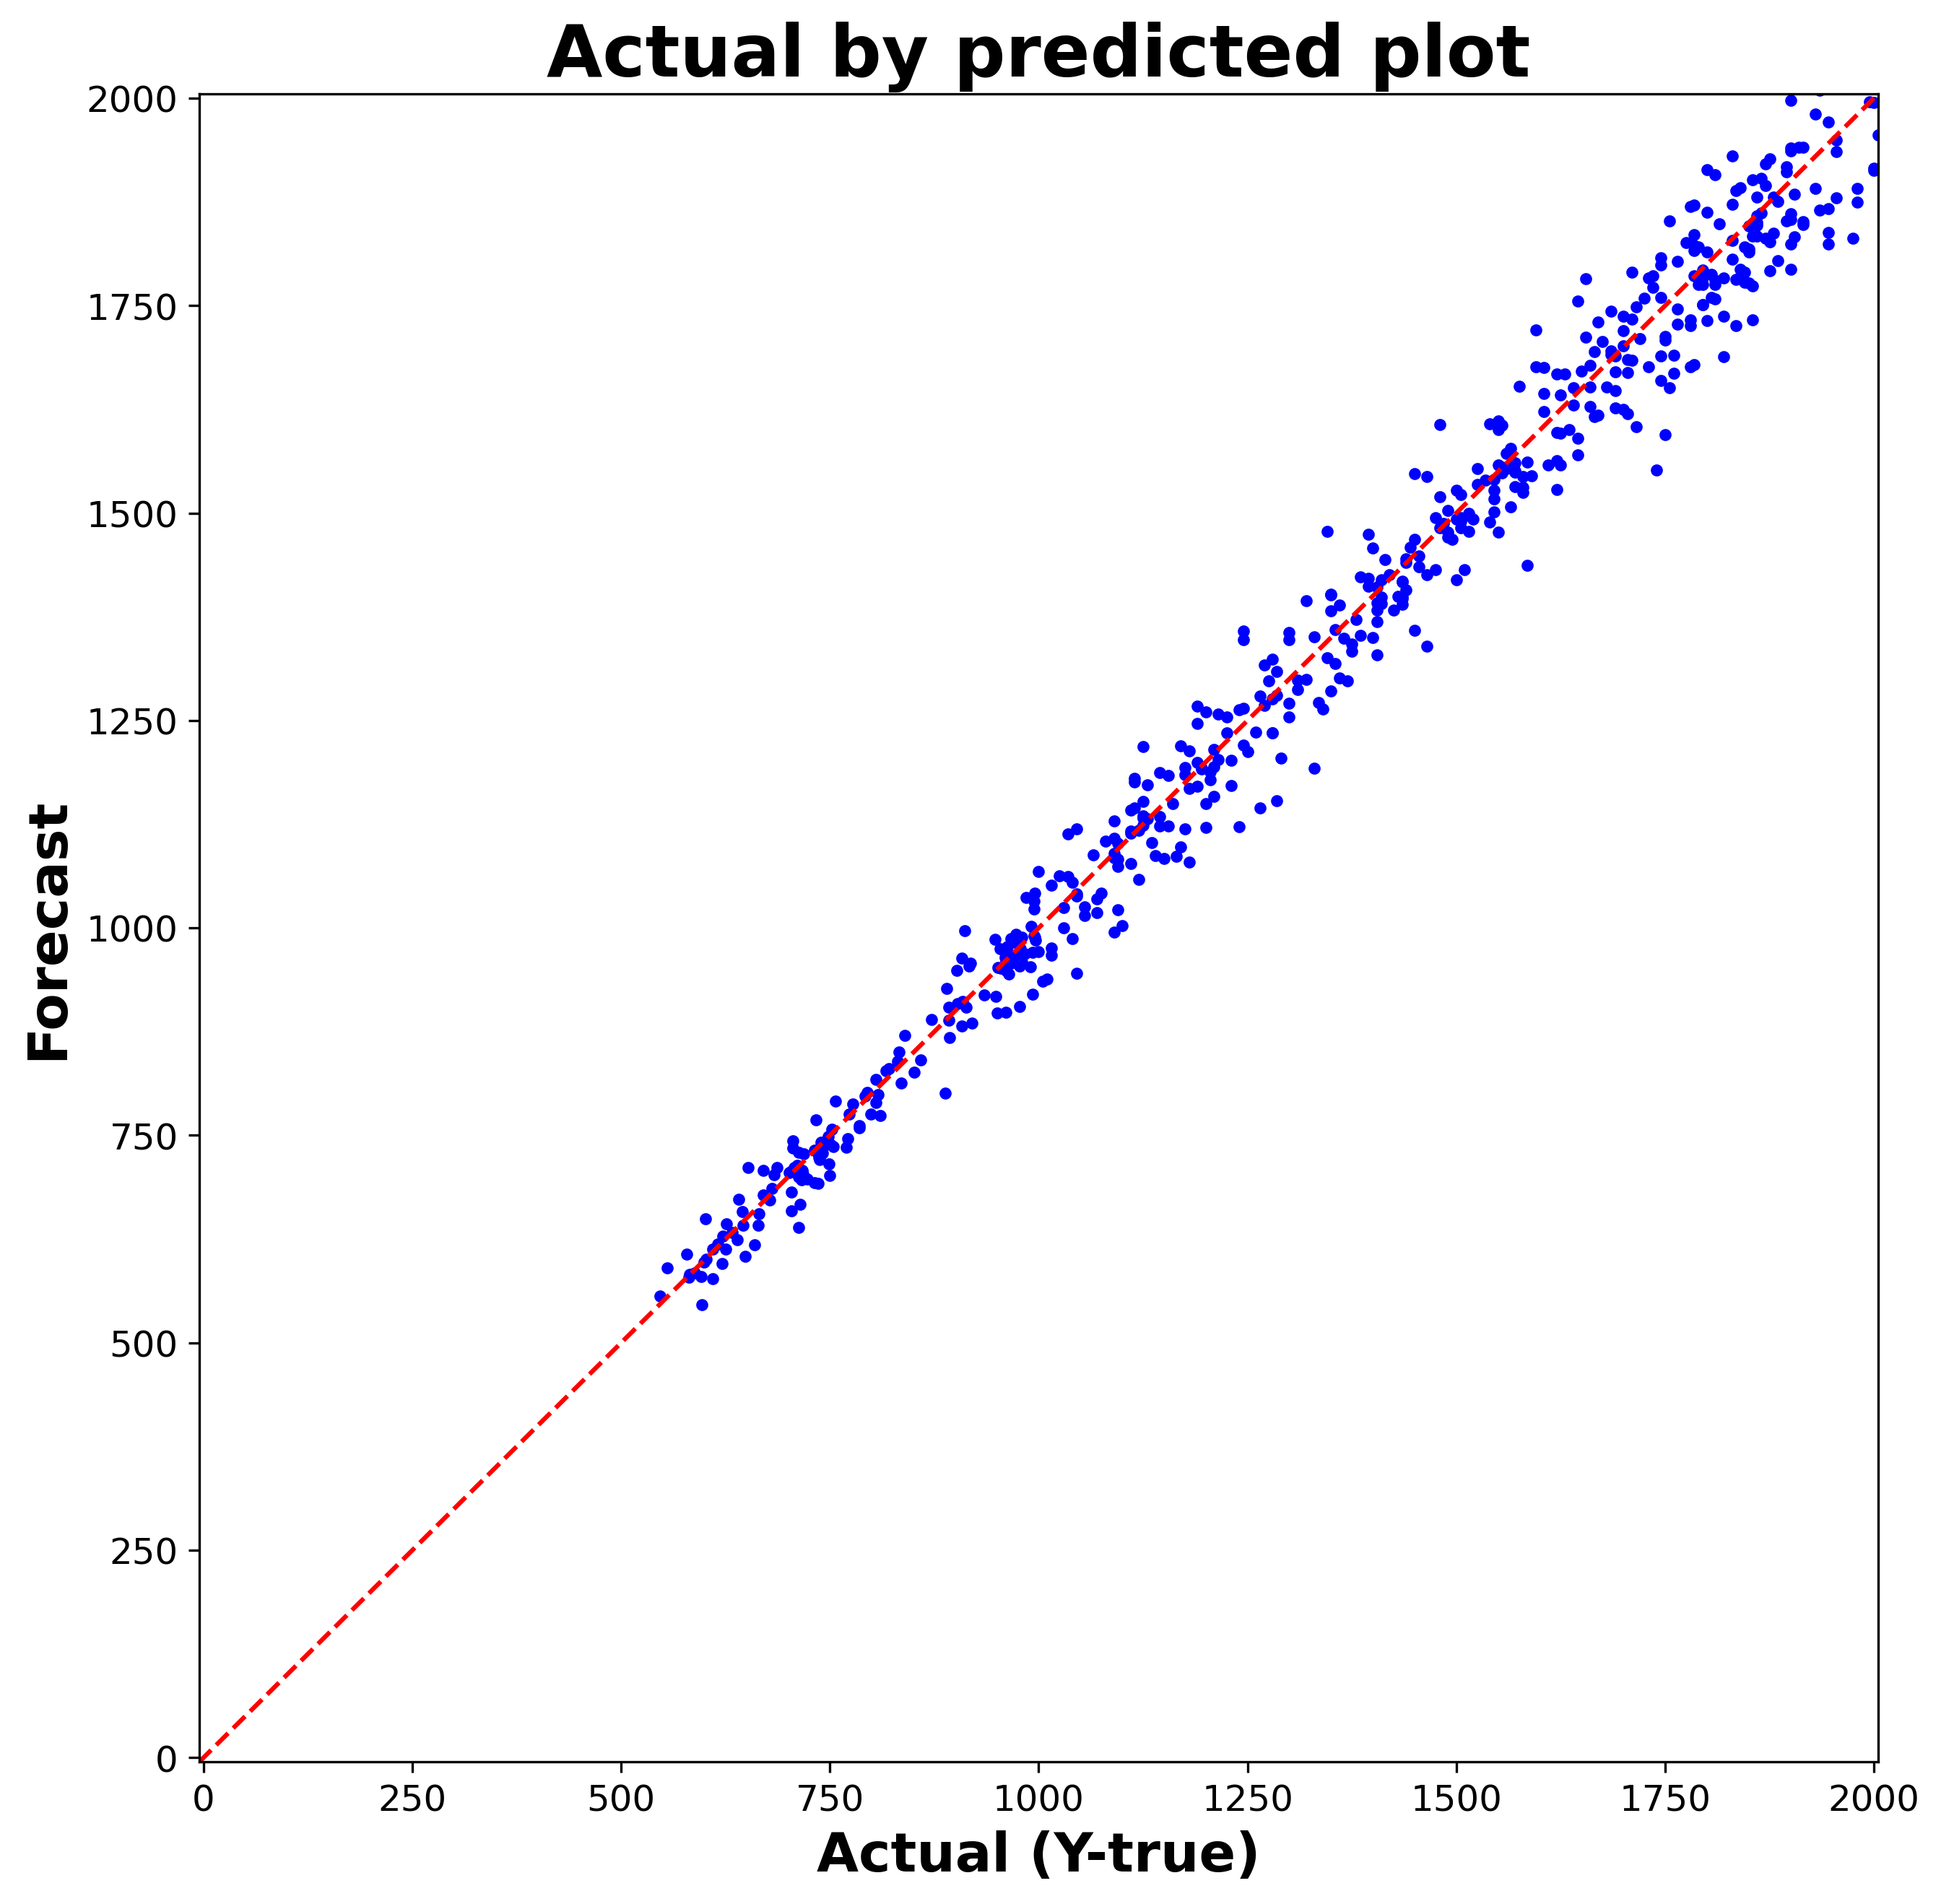

In [98]:
# Lock the scale of axis by Y_true
max_value=2000+5
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()